In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [2]:
stock_data = pd.read_csv('fulldata.csv')
stock_data["FutureOne"]= stock_data.Close.shift(-1)
stock_data["FutureThree"]= stock_data.Close.shift(-3)
stock_data["FutureFive"]= stock_data.Close.shift(-5)
stock_data

,DateTime,Volume,Transaction,Open,High,Low,Close,Dir,Change,ForeignBuy,ForeignSell,ForeignNet,TrustBuy,TrustSell,TrustNet,DealerNet,DealerBuy,DealerSell,InvestorsNet,FutureOne,FutureThree,FutureFive
0,2013-01-02,40647,14353,97.6,99.9,97.1,99.6,+,2.6,22484,8625,13859,1746,147,1599,-350,1300,1650,15108,101.0,100.5,100.0
1,2013-01-03,44335,12616,100.5,102.0,100.0,101.0,+,1.4,32303,17347,14955,926,516,410,-1067,1512,2579,14298,101.5,99.7,101.0
2,2013-01-04,39502,10276,100.5,101.5,100.0,101.5,+,0.5,33581,24337,9244,234,190,44,-246,910,1156,9042,100.5,100.0,101.0
3,2013-01-07,42328,9042,101.0,101.0,99.1,100.5,-,1.0,26613,26952,-339,203,925,-722,-450,871,1321,-1511,99.7,101.0,102.0
4,2013-01-08,31218,9463,99.6,100.0,98.9,99.7,-,0.8,16628,15087,1540,209,635,-426,-80,749,829,1034,100.0,101.0,100.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2509,2023-04-11,23087,24432,522.0,527.0,522.0,524.0,-,5.0,14194,15666,-1472,167,1392,-1225,635,795,159,-2061,520.0,516.0,NaN
2510,2023-04-12,24772,37158,523.0,524.0,517.0,520.0,-,4.0,11989,18261,-6271,73,611,-538,342,624,282,-6467,510.0,520.0,NaN
2511,2023-04-13,27501,64834,515.0,517.0,510.0,510.0,-,10.0,11216,20506,-9289,203,357,-154,-202,244,446,-9646,516.0,NaN,NaN
2512,2023-04-14,21174,19962,516.0,520.0,513.0,516.0,+,6.0,15665,11840,3825,111,280,-169,304,705,401,3960,520.0,NaN,NaN


In [9]:
target = ['FutureFive']
features = ['Transaction','Open', 'High', 'Low','Close','ForeignNet','TrustNet','DealerNet']
df = stock_data[features + target]

In [10]:
# split the data
split = int(df.shape[0] * 0.8)
df_train = df.iloc[:split, :].copy()
df_test = df.iloc[split:, :].copy()

# scale the data
target_scaler = MinMaxScaler().fit(df[target])
df_train[target] = target_scaler.transform(df_train[target])
df_test[target] = target_scaler.transform(df_test[target])

features_scaler = MinMaxScaler().fit(df[features])
df_train[features] = features_scaler.transform(df_train[features])

df_test[features] = features_scaler.transform(df_test[features])

# extract the input sequences and output values
sequence_length = 3

X_train, y_train = [], []

for i in range(sequence_length, df_train.shape[0]):
    X_train.append(df_train[features].iloc[i - sequence_length: i])
    y_train.append(df_train[target].iloc[i])

X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []

for i in range(sequence_length, df_test.shape[0]):
    X_test.append(df_test[features].iloc[i - sequence_length: i])
    y_test.append(df_test[target].iloc[i])

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape)
print(X_test.shape)

(2008, 3, 7)
(500, 3, 7)


In [11]:
# build and train the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
# model.add(LSTM(units=200, activation="tanh", return_sequences=False))
# model.add(Dropout(0.2))
# model.add(LSTM(units=20, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=60, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=120, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(Dense(units=50))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 50)             11600     
                                                                 
 dropout_2 (Dropout)         (None, 3, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 73,021
Trainable params: 73,021
Non-trai

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

train_history=model.fit(X_train, y_train, epochs=50, batch_size=64)

model.evaluate(X_test, y_test)

# #save the model
# model.save('save\LSTM_eps50_bsize64.h5')

# generate the test set predictions
y_pred = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred)

Epoch 1/50
32/32 [==============================] - 2s 6ms/step - loss: 0.0171
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 7.8092e-04
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 7.7443e-04
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 7.8638e-04
Epoch 6/50
32/32 [==============================] - 0s 6ms/step - loss: 6.7416e-04
Epoch 7/50
32/32 [==============================] - 0s 6ms/step - loss: 5.3933e-04
Epoch 8/50
32/32 [==============================] - 0s 5ms/step - loss: 5.5588e-04
Epoch 9/50
32/32 [==============================] - 0s 6ms/step - loss: 5.3237e-04
Epoch 10/50
32/32 [==============================] - 0s 6ms/step - loss: 5.1390e-04
Epoch 11/50
32/32 [==============================] - 0s 6ms/step - loss: 5.0785e-04
Epoch 12/50
32/32 [==============================] - 0s 6ms/step - loss: 5.5449e-04
Epoch 13/

In [13]:
# plot the test set predictions
df['Predicted'] = np.nan
df['Predicted'].iloc[- y_pred.shape[0]:] = y_pred.flatten()
# plot=df[['Close', 'Predicted Close']].plot()
# fig = plot.get_figure()
# fig.savefig("multi_intput_LSTM_model_eps32_bsize64.png")
res=pd.concat([stock_data['DateTime'],df],axis=1)
test=res[['DateTime','Open','Close', 'Predicted']].dropna().reset_index(drop=True)
test

,DateTime,Open,Close,Predicted
0,2021-03-29,599.0,599.0,563.295715
1,2021-03-30,600.0,597.0,581.364868
2,2021-03-31,596.0,587.0,592.044556
3,2021-04-01,598.0,602.0,593.953247
4,2021-04-06,615.0,610.0,595.396484
...,...,...,...,...
495,2023-04-11,522.0,524.0,532.633057
496,2023-04-12,523.0,520.0,532.085754
497,2023-04-13,515.0,510.0,527.657349
498,2023-04-14,516.0,516.0,521.280457


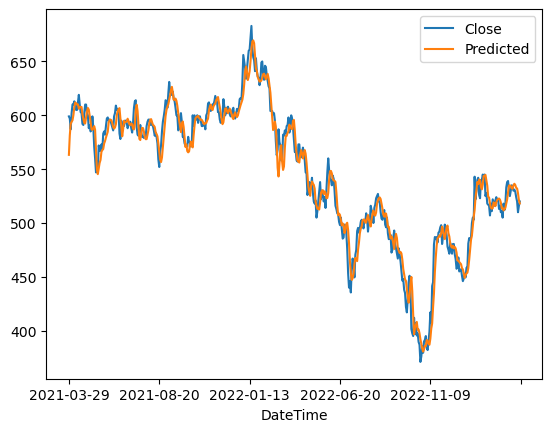

In [14]:
plot=test.plot(x='DateTime',y=['Close','Predicted'])
fig = plot.get_figure()
# fig.savefig("save\LSTM_eps32_bsize64.png")

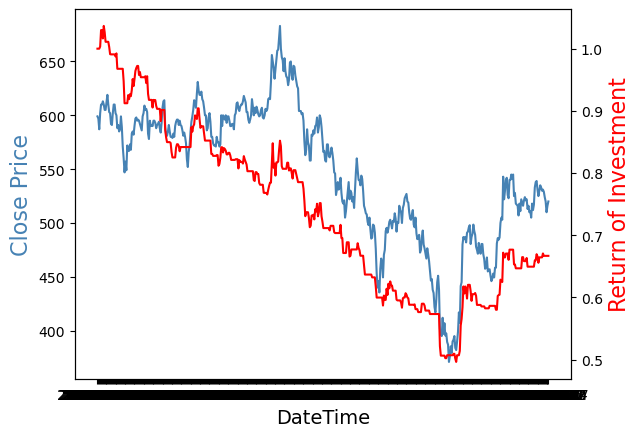

In [24]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
test.loc[test.Predicted.shift(1) >= test.Close.shift(1), "PredvsTrend"]= 0
test.loc[test.Predicted.shift(1) < test.Close.shift(1), "PredvsTrend"]= 1
test['PredvsTrend']=test['PredvsTrend'].fillna(0).astype(int)

test['status3']= test.PredvsTrend.shift(1).fillna(0).astype(int)
test.loc[( (test.PredvsTrend.shift(1)==0) & (test.PredvsTrend==1) ) & (test.Close.shift(1)<=test.Close.shift(2)) & (test.Open <= test.Close.shift(1)) , "status3"]= 0
test.loc[( (test.PredvsTrend.shift(1)==1) & (test.PredvsTrend==0) ) & (test.Close.shift(1)>=test.Close.shift(2)) & (test.Open <= test.Close.shift(1)) , "status3"]= 1

test['buy_cost'] = test.Open[np.where((test.status3 == 1) * (test.status3.shift(1) == 0))[0]]
test['sell_cost'] = test.Open[np.where((test.status3 == 0) * (test.status3.shift(1) == 1))[0]]

test = test.fillna(0)
buy_cost = np.array(test.buy_cost[test.buy_cost != 0])
sell_price = np.array(test.sell_cost[test.sell_cost != 0])

if len(buy_cost) > len(sell_price) :
    buy_cost = buy_cost[:-1]

trade_return = sell_price / buy_cost - 1
fee = 0.002
net_trade_return = trade_return - fee

test['trade_ret'] = 0
test['net_trade_ret'] = 0
sell_dates = test.sell_cost[test.sell_cost != 0].index
test.loc[sell_dates, 'trade_ret'] = trade_return
test.loc[sell_dates, 'net_trade_ret'] = net_trade_return

test['open_ret'] = test.Open / test.Open.shift(1) - 1
test['strategy_ret'] = test.status3.shift(1) * test.open_ret  #status
test['strategy_net_ret'] = test.strategy_ret
test.loc[sell_dates, 'strategy_net_ret'] = test.loc[sell_dates, 'strategy_net_ret'] - fee
test = test.fillna(0)

test['buy_and_hold_equity'] = (test.open_ret + 1).cumprod()
test['strategy_equity'] = (test.strategy_ret + 1).cumprod()
test['strategy_net_equity'] = (test.strategy_net_ret + 1).cumprod()

col1 = 'steelblue'
col2 = 'red'
col3 = 'green'
fig2,ax = plt.subplots()
ax.plot(test.DateTime, test.Close, color=col1)
ax.set_xlabel('DateTime', fontsize=14)
ax.set_ylabel('Close Price', color=col1, fontsize=16)
ax2 = ax.twinx()
ax2.plot(test.DateTime, test.strategy_net_equity, color=col2)
ax2.set_ylabel('Return of Investment', color=col2, fontsize=16)
x_major_locator = MultipleLocator(100)
plt.show()

In [19]:
# dfpred=test[['DateTime','Open','Close', 'Predicted']].dropna().reset_index(drop=True)
# dfpred.to_csv('testpred.csv', encoding='utf-8',index=None)
# #save the model
# model.save('FutureFive.h5')